# Intro to Machine Learning (Regression Tree, Bagging, and Random Forest)

Partially based on the QuantEcon open source code for economic modeling
https://datascience.quantecon.org/applications/


## Introduction to Regression

The goal of regression analysis is to provide accurate mapping from one or
more input variables (called features in machine learning or exogenous
variables in econometrics) to a continuous output variable (called the label or
target in machine learning and the endogenous variable in
econometrics).

In this lecture, we will study some regression algorithms.

We will follow this same general pattern when we learn each algorithm:

- Describe the mathematical foundation for the algorithm  
- Use the [scikit-learn](https://scikit-learn.org/stable/) python package to
  apply the algorithm to a real world dataset on house prices in Washington state  

### Dataset

Let’s load the dataset and take a quick look at our task.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, pipeline, model_selection
)

url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

This dataset contains sales prices on houses in King County (which
includes Seattle),
Washington, from May 2014 to May 2015.

The data comes from
[Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) . Variable definitions and additional documentation are available at that link.

In [111]:
X = df.drop(["price", "date", "id"], axis=1).copy()
# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [112]:
# notice the log here!
y = np.log(df["price"])
df["log_price"] = y
y.head()

0    12.309982
1    13.195614
2    12.100712
3    13.311329
4    13.142166
Name: price, dtype: float64

While we will be using all variables in `X` in our regression models,
we will explain some algorithms that use only the `sqft_living` variable.

Here’s what the log house price looks like against `sqft_living`:

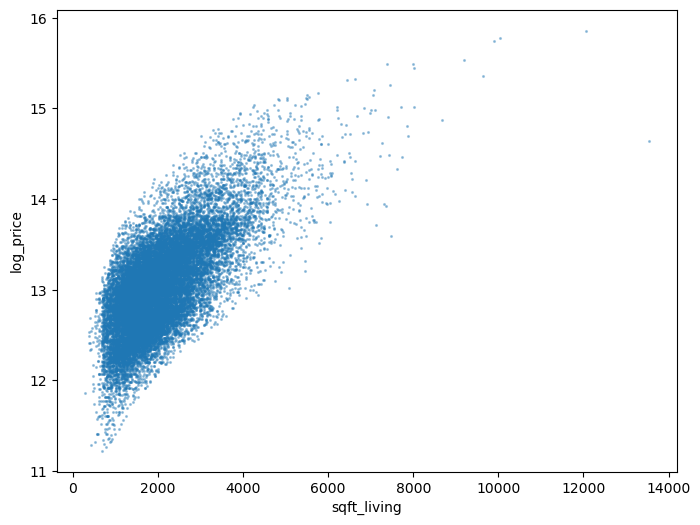

In [113]:
def var_scatter(df, ax=None, var="sqft_living"):
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 6))
    df.plot.scatter(x=var , y="log_price", alpha=0.35, s=1.5, ax=ax)

    return ax

var_scatter(df);

## Linear Regression

Let’s dive in by studying the [“Hello World”](https://en.wikipedia.org/wiki/%22Hello,_World!%22_program) of regression
algorithms: linear regression.

Suppose we would like to predict the log of the sale price of a home, given
only the livable square footage of the home.

The linear regression model for this situation is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} + \epsilon
$$

$ \beta_0 $ and $ \beta_1 $ are called parameters (also coefficients or
weights). The machine learning algorithm is tasked with finding the parameter values
that best fit the data.

$ \epsilon $ is the error term. It would be unusual for the observed
$ \log(\text{price}) $ to be an exact linear function of
$ \text{sqft_living} $. The error term captures the deviation of
$ \log(\text{price}) $ from a linear function of $ \text{sqft_living} $.

The linear regression algorithm will choose the parameters that minimize the
*mean squared error* (MSE) function, which for our example is written.

$$
\frac{1}{N} \sum_{i=1}^N \left(\log(\text{price}_i) - (\beta_0 + \beta_1 \text{sqft_living}_i) \right)^2
$$

The output of this algorithm is the straight line (hence linear) that passes as
close to the points on our scatter chart as possible.

The `sns.lmplot` function below will plot our scatter chart and draw the
optimal linear regression line through the data.

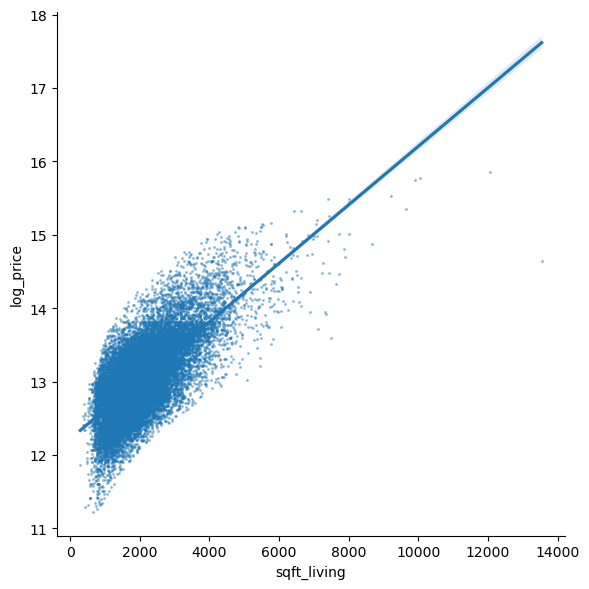

In [114]:
sns.lmplot(
    data=df, x="sqft_living", y="log_price", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35)
);

Let’s use `sklearn` to replicate the figure ourselves. Running a regression with `statmodels` that we used in the previous lab prints nicer outputs with more statistical features.

First, we fit the model.

In [115]:
# import
from sklearn import linear_model

# construct the model instance
sqft_lr_model = linear_model.LinearRegression()

# fit the model
sqft_lr_model.fit(X[["sqft_living"]], y)

# print the coefficients
beta_0 = sqft_lr_model.intercept_
beta_1 = sqft_lr_model.coef_[0]

print(f"Fit model: log(price) = {beta_0:.4f} + {beta_1:.4f} sqft_living")

Fit model: log(price) = 12.2185 + 0.0004 sqft_living


Then, we construct the plot.

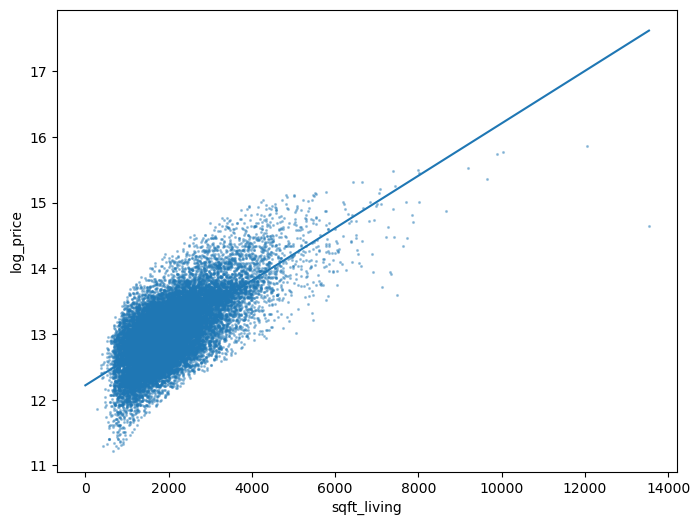

In [116]:
ax = var_scatter(df)

# points for the line
x = np.array([0, df["sqft_living"].max()])
ax.plot(x, beta_0 + beta_1*x)

We can call the `predict` method on our model to evaluate the model at
arbitrary points.

For example, we can ask the model to predict the sale price of a 5,000-square-foot home.

In [117]:
sqft_lr_model.predict([[5000]])

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



array([14.21219679])

In [118]:
# Note, the argument needs to be two-dimensional.
logp_5000 = sqft_lr_model.predict([[5000]])[0]
print(f"The model predicts a 5,000 sq. foot home would cost {np.exp(logp_5000):.2f} dollars")

The model predicts a 5,000 sq. foot home would cost 1486889.32 dollars


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



### Multivariate Linear Regression

Our example regression above is called a bivariate linear
regression since it uses a single feature.

In practice, more features would be used.

Suppose that in addition to `sqft_living`, we also wanted to use the `bathrooms` variable.

In this case, the linear regression model is

$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} +
\beta_2 \text{bathrooms} + \epsilon
$$

We could keep adding one variable at a time, along with a new $ \beta_{j} $ coefficient for the :math:`j`th variable, but there’s an easier way.

Let’s write this equation in vector/matrix form as

$$
\underbrace{\begin{bmatrix} \log(\text{price}_1) \\ \log(\text{price}_2) \\ \vdots \\ \log(\text{price}_N)\end{bmatrix}}_Y = \underbrace{\begin{bmatrix} 1 & \text{sqft_living}_1 & \text{bathrooms}_1 \\ 1 & \text{sqft_living}_2 & \text{bathrooms}_2 \\ \vdots & \vdots & \vdots \\ 1 & \text{sqft_living}_N & \text{bathrooms}_N \end{bmatrix}}_{X} \underbrace{\begin{bmatrix} \beta_0 \\ \beta_1 \\ \beta_2 \end{bmatrix}}_{\beta} + \epsilon
$$

Notice that we can add as many columns to $ X $ as we’d like and the linear
regression model will still be written $ Y = X \beta + \epsilon $.

The mean squared error loss function for the general model is

$$
\frac{1}{N} \sum_{i=1}^N (y_i - X_i \beta)^2 = \frac{1}{N} \| y - X \beta\|_2^2
$$

where $ || \cdot ||_2 $ is the [l2-norm](http://mathworld.wolfram.com/L2-Norm.html).

Let’s fit the linear regression model using all columns in `X`.

In [119]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0
1,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,47.7210,-122.319,1690.0,7639.0
2,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0
3,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,47.5208,-122.393,1360.0,5000.0
4,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0


In [120]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

LinearRegression()

In [121]:
print(lr_model.intercept_)
print(lr_model.coef_)

-5.07269190225238
[-1.22081975e-02  6.91236975e-02  9.57346983e-05  4.71182260e-07
  7.51533563e-02  3.71195130e-01  6.04046629e-02  6.26365810e-02
  1.58933766e-01  4.02240768e-05  5.55106213e-05 -3.41052046e-03
  3.65904384e-05 -6.45883644e-04  1.39999366e+00 -1.59156503e-01
  9.85662254e-05 -2.61006602e-07]


In [122]:
y_pred_linear = lr_model.predict(X)
from sklearn import metrics
full_mse = metrics.mean_squared_error(y, y_pred_linear)
print('Mean Squared Error:', full_mse)

Mean Squared Error: 0.0636750926661074


### Nonlinear Relationships in Linear Regression

While it sounds like an oxymoron, a linear regression model can actually include non-linear features.

The distinguishing feature of the linear regression model is that each
prediction is generated by taking the dot product (a linear operator) between a
feature vector (one row of $ X $) and a coefficient vector ($ \beta $).

There is, however, no restriction on what element we include in our feature
vector.

Let’s consider an example…
$$
\log(\text{price}) = \beta_0 + \beta_1 \text{sqft_living} +
\beta_2 \text{(sqft_above / sqft_living)} + \epsilon
$$

Starting from the `sqft_living`-only model, suppose we have a hunch that we
should also include the *fraction of square feet above ground*.

This last variable can be computed as `sqft_above / sqft_living`.

This second feature is nonlinear, but could easily be included as a column in
`X`.

Let’s see this in action.

In [123]:
X2 = X[["sqft_living"]].copy()
X2["pct_sqft_above"] = X["sqft_above"] / X["sqft_living"]

sqft_above_lr_model = linear_model.LinearRegression()
sqft_above_lr_model.fit(X2, y)

new_mse = metrics.mean_squared_error(y, sqft_above_lr_model.predict(X2))
old_mse = metrics.mean_squared_error(y, sqft_lr_model.predict(X2[["sqft_living"]]))
print(f"The mse changed from {old_mse:.4f} to {new_mse:.4f} by including our new feature,\n The full model mse is {full_mse:.4f}")

The mse changed from 0.1433 to 0.1430 by including our new feature,
 The full model mse is 0.0637



Determining which columns belong in $ X $ is called *feature
engineering* and is a large part of a machine learning practitioner’s job.

You may recall from (or will see in) your econometrics course(s) that
choosing which control variables to include in a regression model
is an important part of applied research.

### Interpretability

Before moving to our next regression model, we want to broach the idea of
the **interpretability** of models.

An interpretable model is one for which we can analyze the
coefficients to explain why it makes its predictions.

Recall $ \beta_0 $ and $ \beta_1 $ from the univariate model.

The interpretation of the model is that $ \beta_0 $ captures the notion of
the average or starting house price and $ \beta_1 $ is the additional value
per square foot.

Concretely, we have

In [124]:
beta_0, beta_1

(12.218464096380853, 0.0003987465387451504)

which means that our model predicts the log price of a house to be 12.22, plus
an additional 0.0004 for every square foot.

Using more exotic machine learning methods might potentially be more accurate but
less interpretable.

The accuracy vs interpretability tradeoff is a hot discussion topic, especially relating
to concepts like machine learning ethics. This is something you
should be aware of as you continue to learn about these techniques.

## Regression Trees
#### Example 1: house price regression
Everything is very similar to fitting a linear model to the data

In [125]:
from sklearn import tree
sqft_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

Above we fit the model. It was easy! lets find its error of predicitons

In [126]:
# use the fitted tree to predict
y_pred_tree = sqft_tree.predict(X)

# find the error of prediction (MSE)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Mean Squared Error: 0.09195945281208844


You can see that mean squared error (`mse`) of a tree with depth of 3 is worst than simple linear regression including all Xs. However, you can change the depth of tree and reduce your `mse`. Infact, you can even reduce it to zero if you have a large enough tree. But, in that case your tree is too complicated and will not do a good job in predicting new data points (poor out of sample prediction accuracy). This is called over-fitting. You should find a proper depth for your tree such that is has a low `mse` but a high prediction power. The process of fining the right complication in your ML method is called `Tunning`. We will not cover this but it is not a complicated task. 

Make your tree more complicated (add to `max_dpth`) and see your `mse` will drop. You can even reduce it to zero with a large enough tree. Think about why we do not want to fit such a big tree to our data.

Now, lets plot our tree and see how it looks like. One advantage of trees is that they are easy to interpret, so try to interpret your tree in your projects

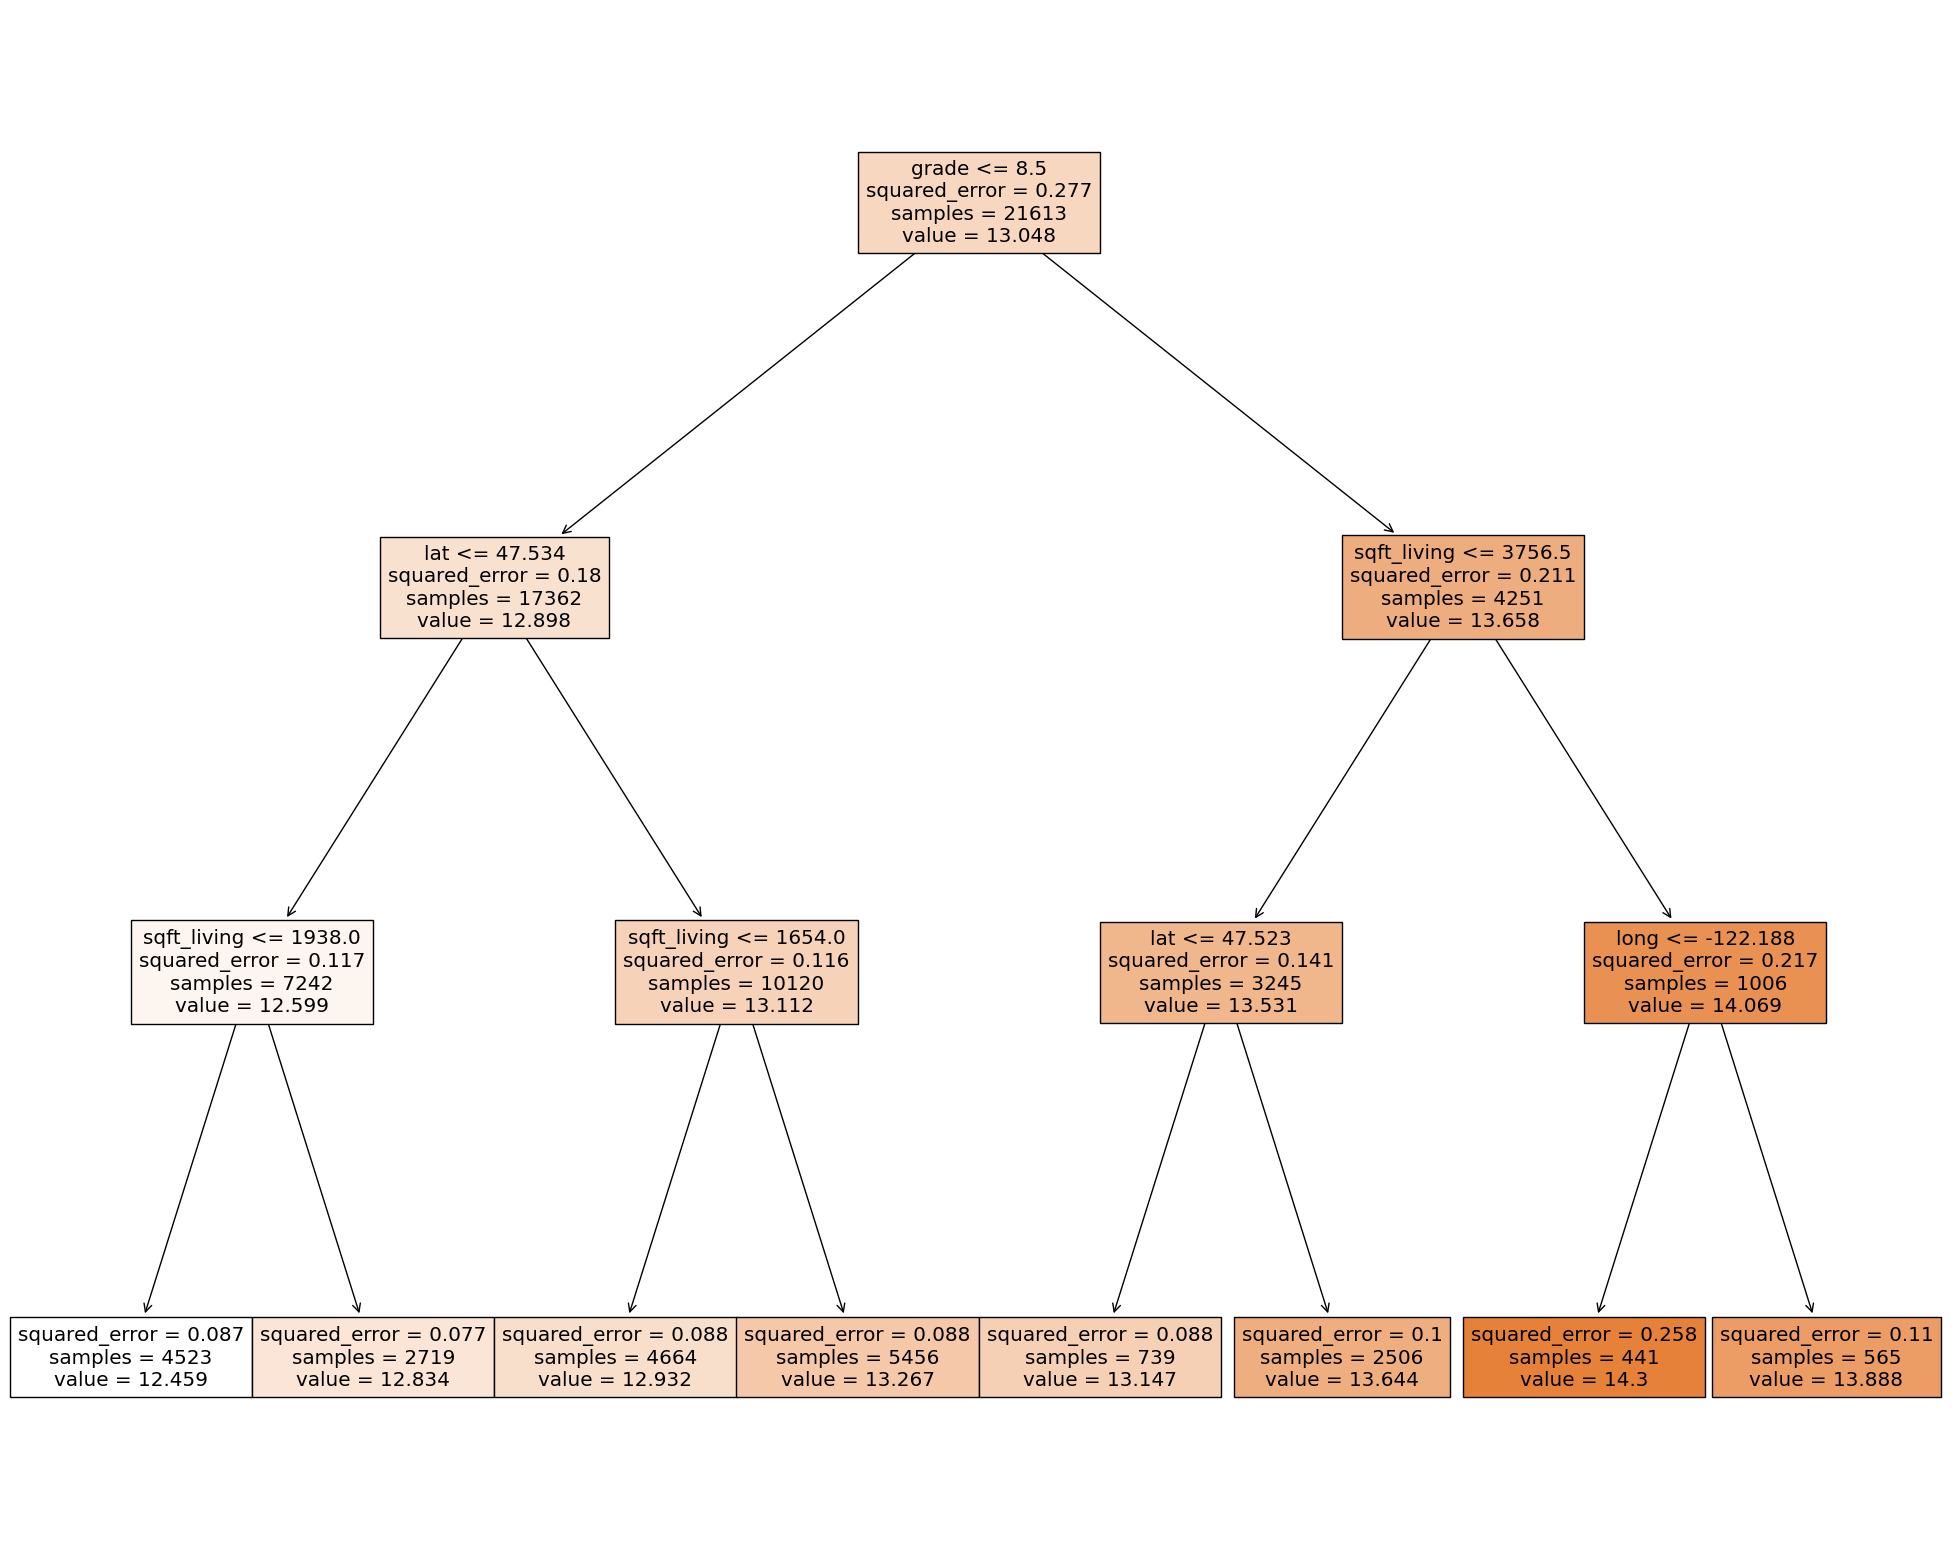

In [127]:
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(sqft_tree, feature_names=X.columns, filled=True)

Regression trees are formed iteratively.

We begin with a rectangular region $ R $ containing all values of
X.

We then choose a feature and location to split on, aiming to minimize MSE.

We then repeat to generate all the branches.

- For each region, solve  


$$
\min_{j,s} \left[  \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (y_i - \hat{y}_{R1})^2 +  \sum_{i: x_{i,j} > s, x_i \in R2}
    (y_i - \hat{y}_{R2})^2 \right]
$$

- Repeat with each of the two smaller rectangles.  
- Stop when $ |R| = $ some chosen minimum size or when depth of tree $ = $
  some chosen maximum.  
- Prune tree.  


$$
\min_{tree \subset T} \sum (\hat{f}(x)-y)^2 + \alpha|\text{terminal
   nodes in tree}|
$$

This tree-building algorithm has many variations, but every variation 1) shares some rule to decide on a splitting variable and location and 2) has a stopping rule (though not necessarily the same one).

For example, some algorithms stop splitting into new branches when the improvement
in MSE becomes small.

As with lasso, regression trees also involve some regularization.

In the above description, the minimum leaf size, maximum tree depth, and
$ \alpha $ in the pruning step serve as regularization
parameters.




You can (should) tune your hyperparameters. We do not cover it in this course since the main focus is not in ML but feel free to uncomment the cell below and experiement with different levels of alpha. 


An advantage of regression trees (and random forests) is that they adapt
automatically to feature scales and units.

For example, including zip code in linear regression or lasso was a little
strange. While zip codes are numerical in value, they actually represent categorical
variables. (i.e. we can compute `10025` - `85001` (NYC and Phoenix), but the numerical difference is meaningless.)

Including an indicator or dummy variable for each zip code would make more sense.

Regression trees do not impose linearity or even monotonicity, so having the numeric zip code as a feature is
less harmful than it could have been in a linear regression.

### Classification Tree 

**Important: if your Y variable is categorical or a dummy, you have a "classification" problem not a "regression" problem. If this is the case, you should run a "classification tree".**

**Please uncomment the code below to run the classification regression.**

This is the case for most ML models. For Bagging, RF, etc., the code should be written for a classification model. 

In [128]:
# import pandas as pd
# from sklearn.tree import DecisionTreeClassifier

# # Simulated data
# data = {
#     'X1': [1, 2, 3, 4, 5],
#     'X2': [2, 3, 4, 5, 6],
#     'Y': ['A', 'B', 'A', 'B', 'B']  # Categorical dependent variable
# }

# # Create DataFrame
# df = pd.DataFrame(data)

# # Separate features (X) and target variable (Y)
# X_cls = df[['X1', 'X2']]
# y_cls = df['Y']

# # Create decision tree classifier with a maximum depth of 3
# tree_classifier = DecisionTreeClassifier(max_depth=3)

# # Fit the classifier to the training data
# tree_classifier.fit(X_cls, y_cls)

# # Get the class labels, now you know that the first number is probability for 'A' and the second number is for 'B'
# class_labels = tree_classifier.classes_
# print("Class labels:", class_labels) 

# # Now you can use this trained classifier to make predictions on new data
# fig_classifier= plt.figure(figsize=(25,20))
# fig_classifier = tree.plot_tree(tree_classifier, feature_names=X_cls.columns, filled=True)

### Ensemble Models/Methods

In general, we can combine the prediction of different models and get a better prediction! We call the pooled model an ensemble model. For instance, instead of looking at the prediction of only one regression tree, you can average the predictions of multiple regression tree models. This is an ensemble method! 

You can also come up with your own ensemble models. Make your own potion!


Picture from: https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c

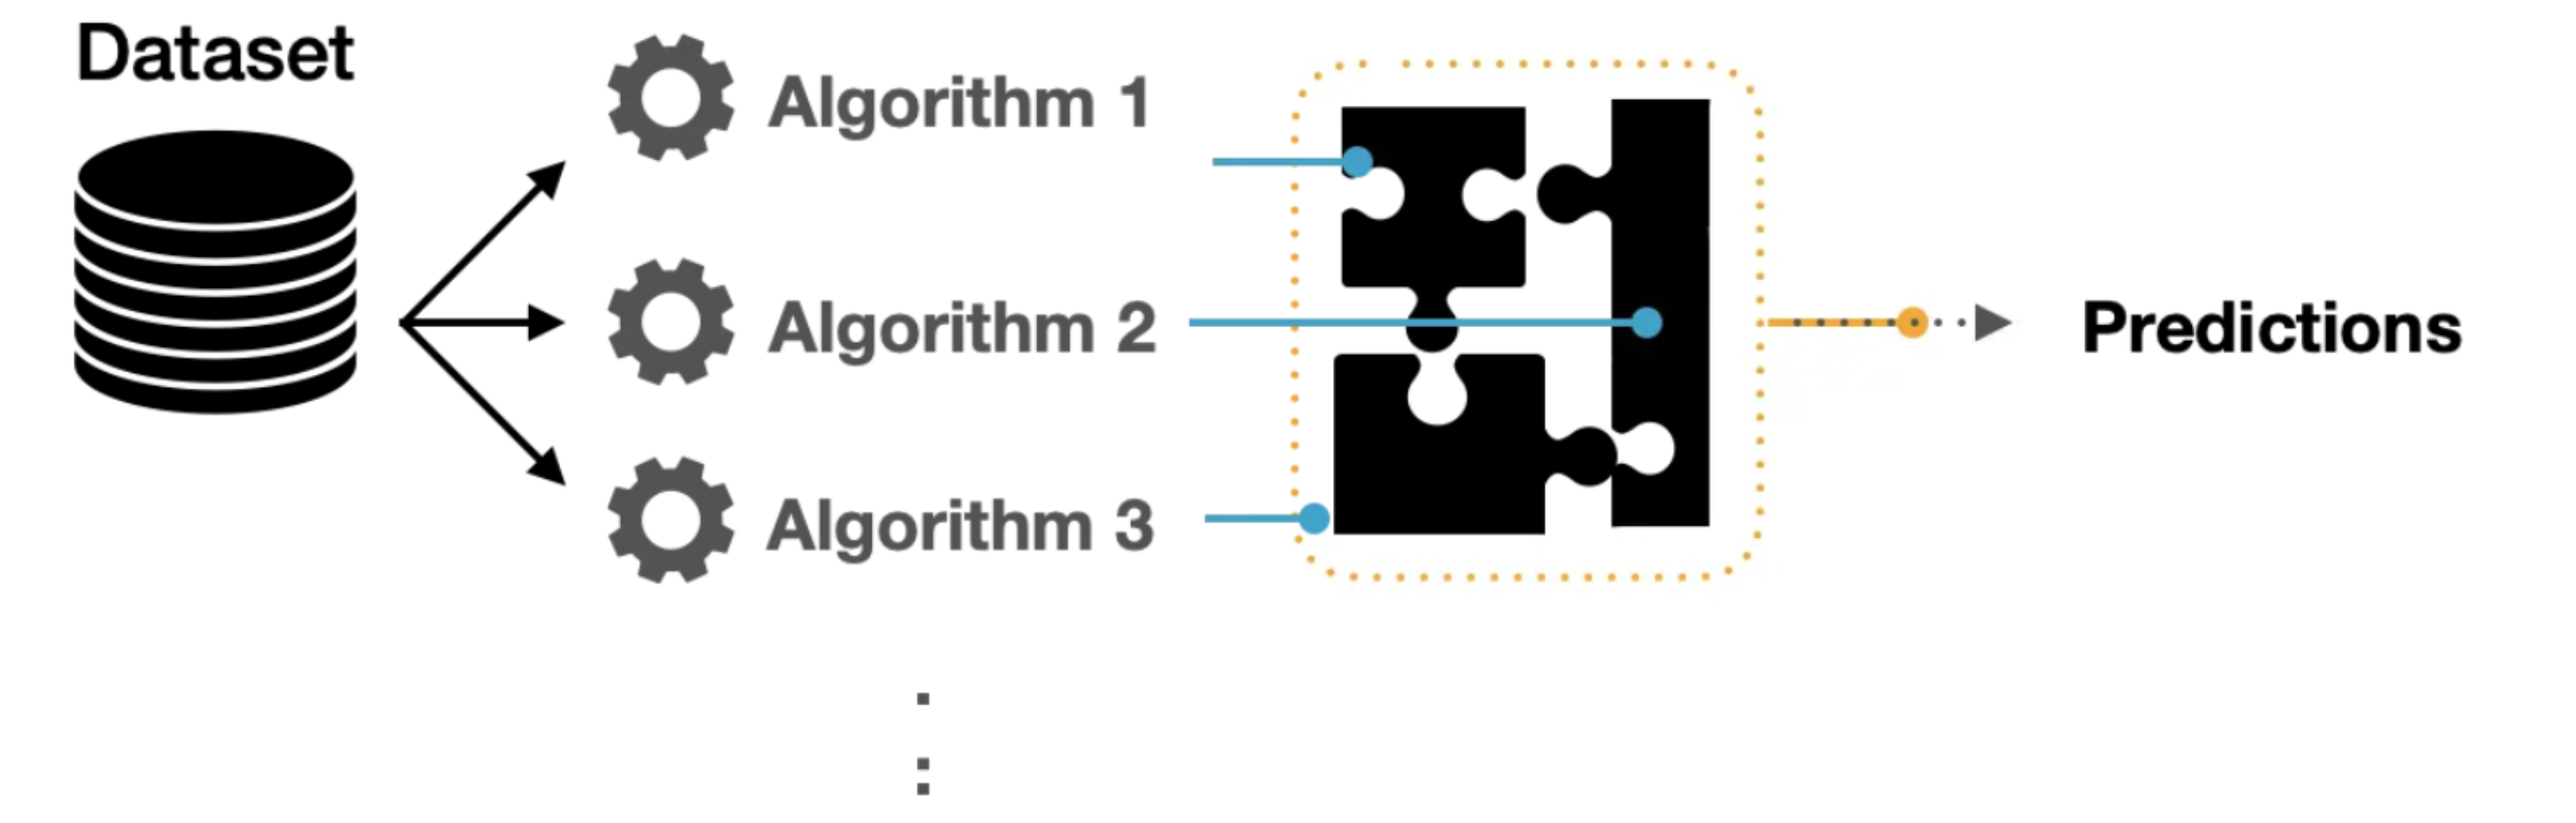

In [129]:
from IPython.display import Image
Image(filename='ensemble.png')

## Bagging (Boostrap Aggregation)
Please read more in chapter 8 of the textbook.

A single tree usually has a high variance. In order to reduce the variance we can fit many trees on the bootstrapped data and look at the average prediction. We can bootstrap by taking repeated samples from our training dataset and run one tree on each of these samples. Each tree is grown deep and is not pruned, hence it has low bias and high variance.

#### What is boostrapping? 
The term sounds scary and complicated but by bootstrapping we just mean sampling with replacement. 
From wikipedia: 
"Bootstrapping is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates.This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods." https://en.wikipedia.org/wiki/Bootstrapping_(statistics)



Picture from: https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c

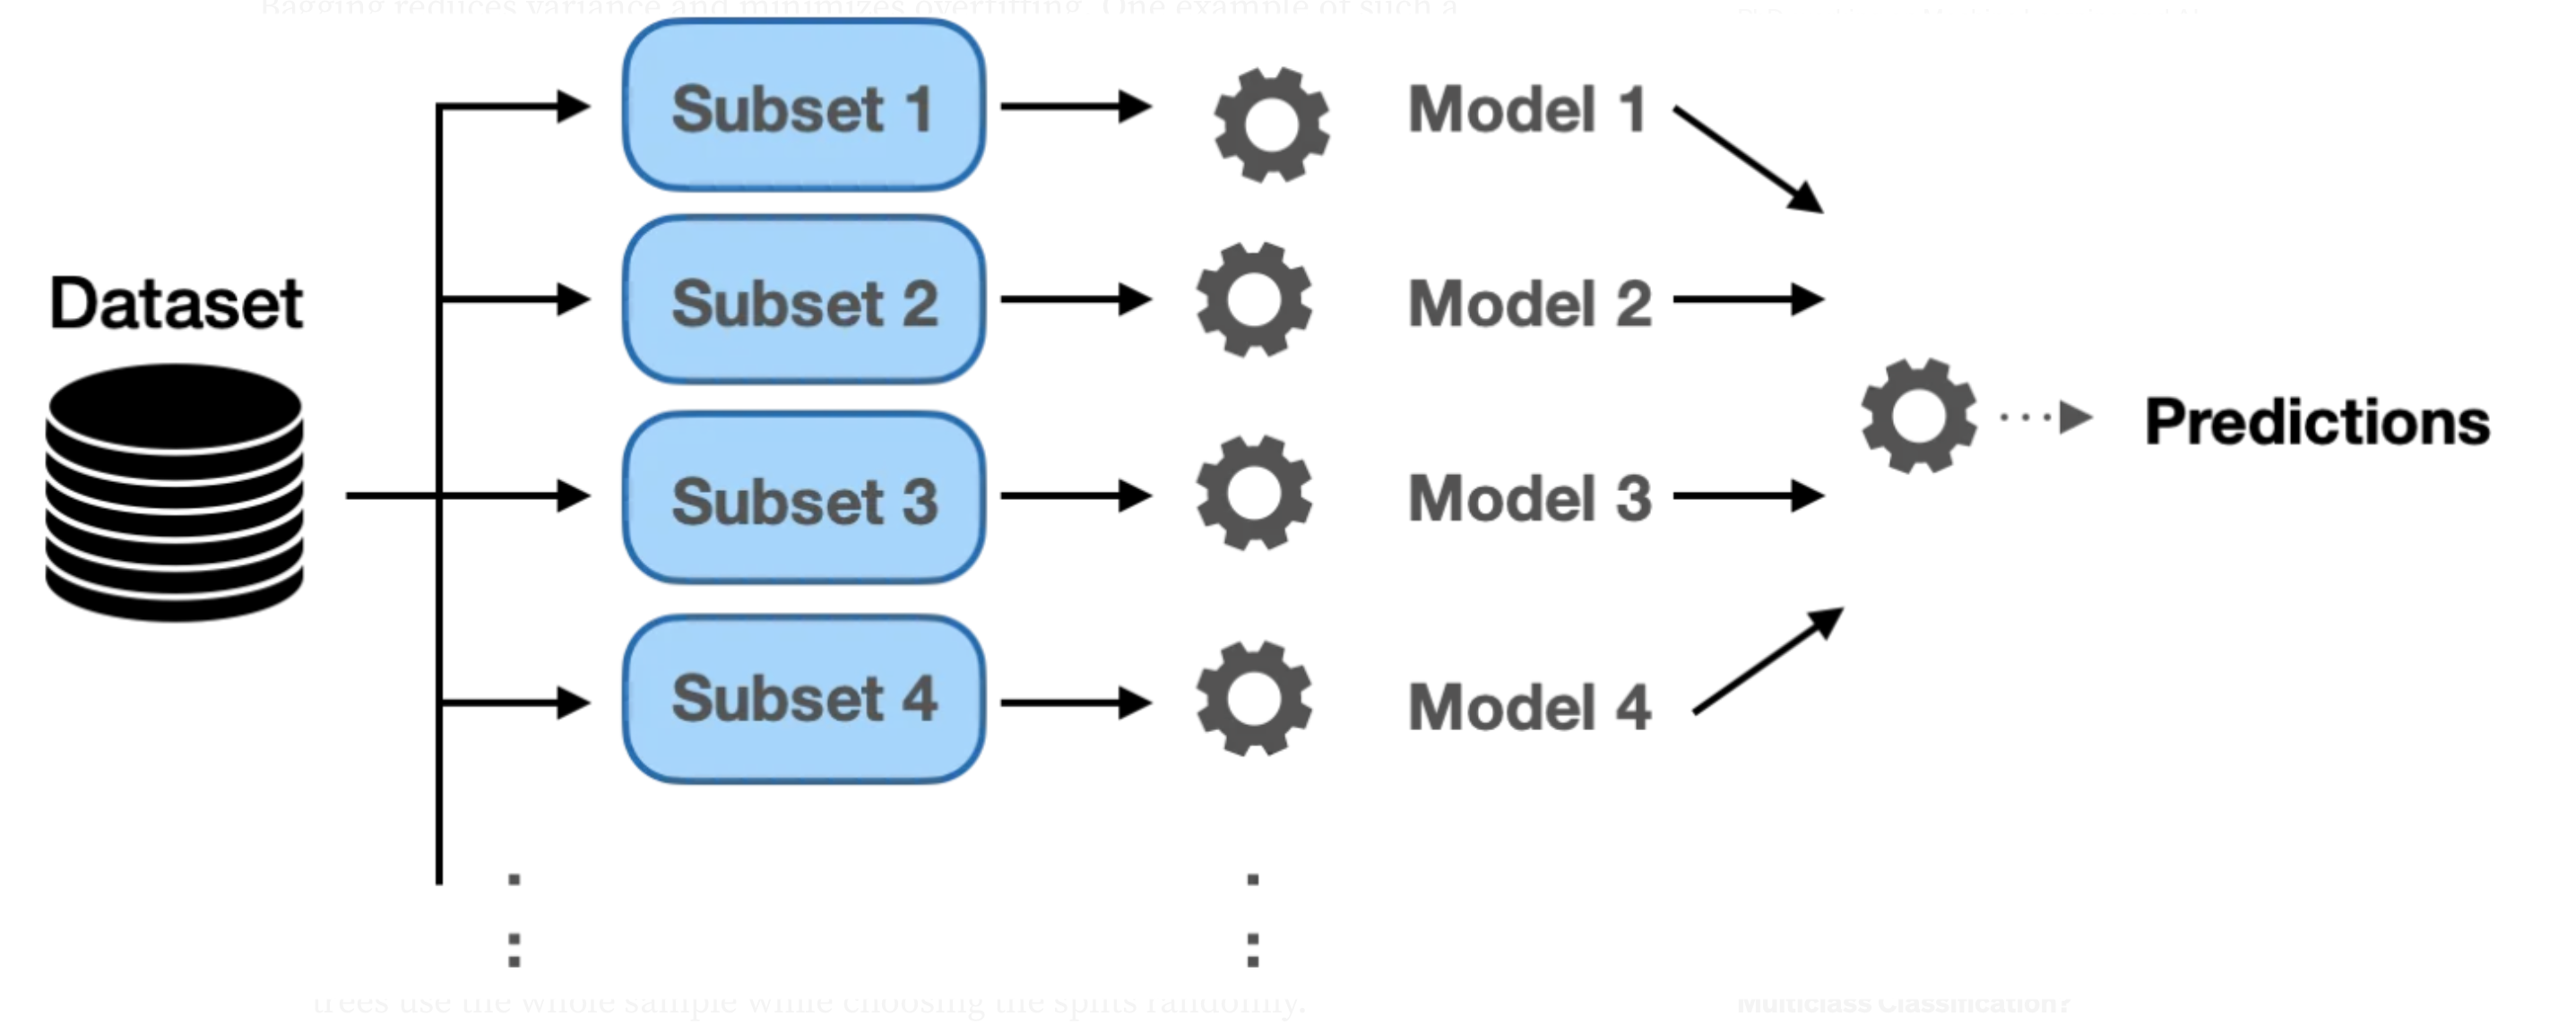

In [130]:
Image(filename='bagging.png')

In [131]:
# let's check the number of features (variables) we have in our X dataset.

len(X.columns)

18

In [132]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In the code below, think about why we use `RandomForestRegressor` to run a Boosting model?!!!

Note that the `random_state=1` controls the randomness of the bootstrapping of the samples used when building trees. Learn more here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


The number that is provided for the `random_state` will be the seed in the random number generator for boostrapping. Setting the seed makes your work reproducible.  

0.004963207138095874

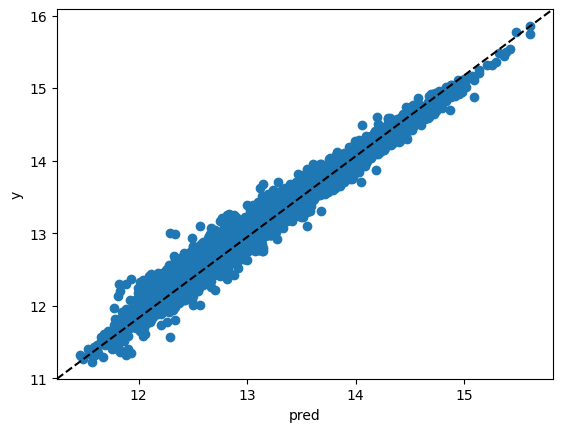

In [133]:
#Bagging; using all features

regr_bagg = RandomForestRegressor(max_features= 18, random_state=1) 
regr_bagg.fit(X, y)


pred = regr_bagg.predict(X)

plt.scatter(pred, y, label='log price')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y')


mean_squared_error(y, pred)

## Random Forest (RF)

Please read more in chapter 8 of the textbook.


Random Forest improves over Bagging models with a teeny tiny yet clever tweak. In Bagging, there is a high chance that the trees are very similar to each other. They may all split on the same variables. For example, if age is an important variable in a given regression, the first split in all of your trees may be age. If the trees are similar (or correlated), then having many trees is not much of an improvement over just a single regression tree, right? 


So, how do we fix this issue? How do we make the trees look different than each other? 

The answer is the difference between RF and Bagging. In Random Forest models, at each node, a random sample of your Xs are selected and then the tree should choose the split variable from this sample of Xs. 

For example, if you have 10 variables, at each node, you can select 5 of the variables randomly and then ask your tree to choose one out of these 5 Xs and split on it. This way if the most important variable is age, age may not be selected in some of the random selections and this forces the trees to split on ther variables and actually look different. 


THIS IS SO BRILLIAAAAAAANT!!!!!!!!




In [134]:
#Random Forest: using 5 features

# define and fit
regr_RF = RandomForestRegressor(max_features=5, random_state=1).fit(X, y)

#predict
pred = regr_RF.predict(X)

#calculate MSE
mean_squared_error(y, pred)

0.0049472376321366

#### Importance Matrix

We can record the total amount that the reduction in mean squared error due to splits over a given predictor, averaged over all trees. If splits on a given predictor (X) results in large reduction in mean squared error, that X is important. 


We can therefore rank all of our Xs based on how much they help us reduce the error and create the importance matrix like below: 

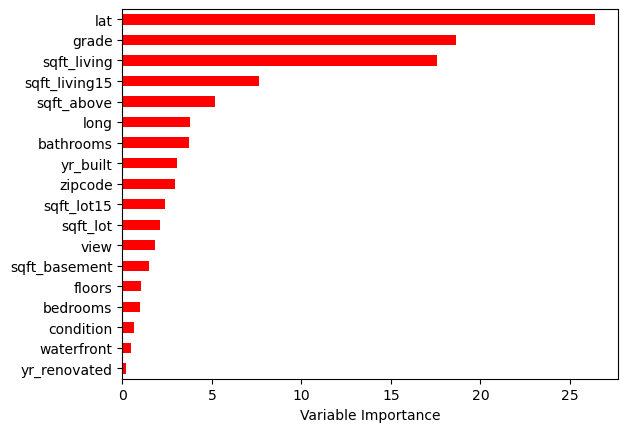

In [135]:
Importance = pd.DataFrame({'Importance':regr_RF.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## References

Two good text books covering the above regression methods are
[[regFHT09]](#reg-friedman2008) and [[regEH16]](#reg-efron2016)

<a id='reg-athey2018'></a>
\[regAI18\] Susan Athey and Guido Imbens. Machine learning and econometrics. 2018. URL: [https://www.aeaweb.org/conference/cont-ed/2018-webcasts](https://www.aeaweb.org/conference/cont-ed/2018-webcasts).

<a id='reg-athey2017'></a>
\[regAI17\] Susan Athey and Guido W. Imbens. The state of applied econometrics: causality and policy evaluation. *Journal of Economic Perspectives*, 31(2):3–32, May 2017. URL: [http://www.aeaweb.org/articles?id=10.1257/jep.31.2.3](http://www.aeaweb.org/articles?id=10.1257/jep.31.2.3), [doi:10.1257/jep.31.2.3](https://doi.org/10.1257/jep.31.2.3).

<a id='reg-belloni2011'></a>
\[regBC11\] Alexandre Belloni and Victor Chernozhukov. *High Dimensional Sparse Econometric Models: An Introduction*, pages 121–156. Springer Berlin Heidelberg, Berlin, Heidelberg, 2011. URL: [https://doi.org/10.1007/978-3-642-19989-9_3](https://doi.org/10.1007/978-3-642-19989-9_3), [doi:10.1007/978-3-642-19989-9_3](https://doi.org/10.1007/978-3-642-19989-9_3).

<a id='reg-chernozhukov2018'></a>
\[regCCD+18\] Victor Chernozhukov, Denis Chetverikov, Mert Demirer, Esther Duflo, Christian Hansen, Whitney Newey, and James Robins. Double/debiased machine learning for treatment and structural parameters. *The Econometrics Journal*, 21(1):C1–C68, 2018. URL: [https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097](https://onlinelibrary.wiley.com/doi/abs/10.1111/ectj.12097), [arXiv:https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097](https://arxiv.org/abs/https://onlinelibrary.wiley.com/doi/pdf/10.1111/ectj.12097), [doi:10.1111/ectj.12097](https://doi.org/10.1111/ectj.12097).

<a id='reg-hdm'></a>
\[regCHS16\] Victor Chernozhukov, Chris Hansen, and Martin Spindler. hdm: high-dimensional metrics. *R Journal*, 8(2):185–199, 2016. URL: [https://journal.r-project.org/archive/2016/RJ-2016-040/index.html](https://journal.r-project.org/archive/2016/RJ-2016-040/index.html).

<a id='reg-efron2016'></a>
\[regEH16\] Bradley Efron and Trevor Hastie. *Computer age statistical inference*. Volume 5. Cambridge University Press, 2016. URL: [https://web.stanford.edu/~hastie/CASI/](https://web.stanford.edu/~hastie/CASI/).

<a id='reg-friedman2008'></a>
\[regFHT09\] Jerome Friedman, Trevor Hastie, and Robert Tibshirani. *The elements of statistical learning*. Springer series in statistics, 2009. URL: [https://web.stanford.edu/~hastie/ElemStatLearn/](https://web.stanford.edu/~hastie/ElemStatLearn/).

<a id='reg-hornik1989'></a>
\[regHSW89\] Kurt Hornik, Maxwell Stinchcombe, and Halbert White. Multilayer feedforward networks are universal approximators. *Neural Networks*, 2(5):359 – 366, 1989. URL: [http://www.sciencedirect.com/science/article/pii/0893608089900208](http://www.sciencedirect.com/science/article/pii/0893608089900208), [doi:https://doi.org/10.1016/0893-6080(89)90020-8](https://doi.org/https://doi.org/10.1016/0893-6080%2889%2990020-8).

# Extra material not required for project

You can (should) tune your hyperparamters which is about two weeks of lecture in an ML course. If you are interested to learn this (not necessary for our course), feel free to uncomment the below code and experiment with your own datasets. Please note that there are many different ways to tune. Before learning to tune, you should learn cross validation which will be covered in a classic machine learning course. 

In [136]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error
# import matplotlib.pyplot as plt

# # Define a range of alpha values
# alpha_values = [1, 5, 10, 50, 100]  # You can adjust this range as needed

# # Dictionary to store MSE values for different alpha values
# mse_scores = {}

# # Iterate over alpha values
# for alpha in alpha_values:
#     # Create and fit the Random Forest regressor with the current alpha value
#     rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=1, random_state=42)
#     rf_regressor.fit(X_train, y_train)
    
#     # Predict on the validation set
#     y_pred = rf_regressor.predict(X_val)
    
#     # Calculate MSE and store it
#     mse = mean_squared_error(y_val, y_pred)
#     mse_scores[alpha] = mse

# # Plot MSE vs. alpha
# plt.plot(alpha_values, list(mse_scores.values()), marker='o')
# plt.title('MSE vs. Alpha')
# plt.xlabel('Alpha')
# plt.ylabel('Mean Squared Error')
# plt.grid(True)
# plt.show()

### Boosting

Boosting improves over the Random Forest model by growing the trees sequentially. In Bagging and RF trees are grown independently on random bootstrapped samples. In Boosting, we run trees sequentially and learn from our previous mistakes!! 

In boosting, we don't run the trees on bootstrapped samples. Trees are run on the same dataset, the only difference is that now we adjust our splits based on the errors of the previous tree. Boosting models learn slowly compared to Bagging and RF. 

You can control the rate at which your boosting model learns using the shrinkage parameter. 


"In boosting, we only use the original data, and do not draw any ran- dom samples. The trees are grown successively, using a “slow” learning approach: each new tree is fit to the signal that is left over from the earlier trees, and shrunken down before it is used"

You can use the `xgboost` library to run this model. We are not demonstrating an example in this lab. 


Picture from: https://towardsdatascience.com/ensemble-models-5a62d4f4cb0c

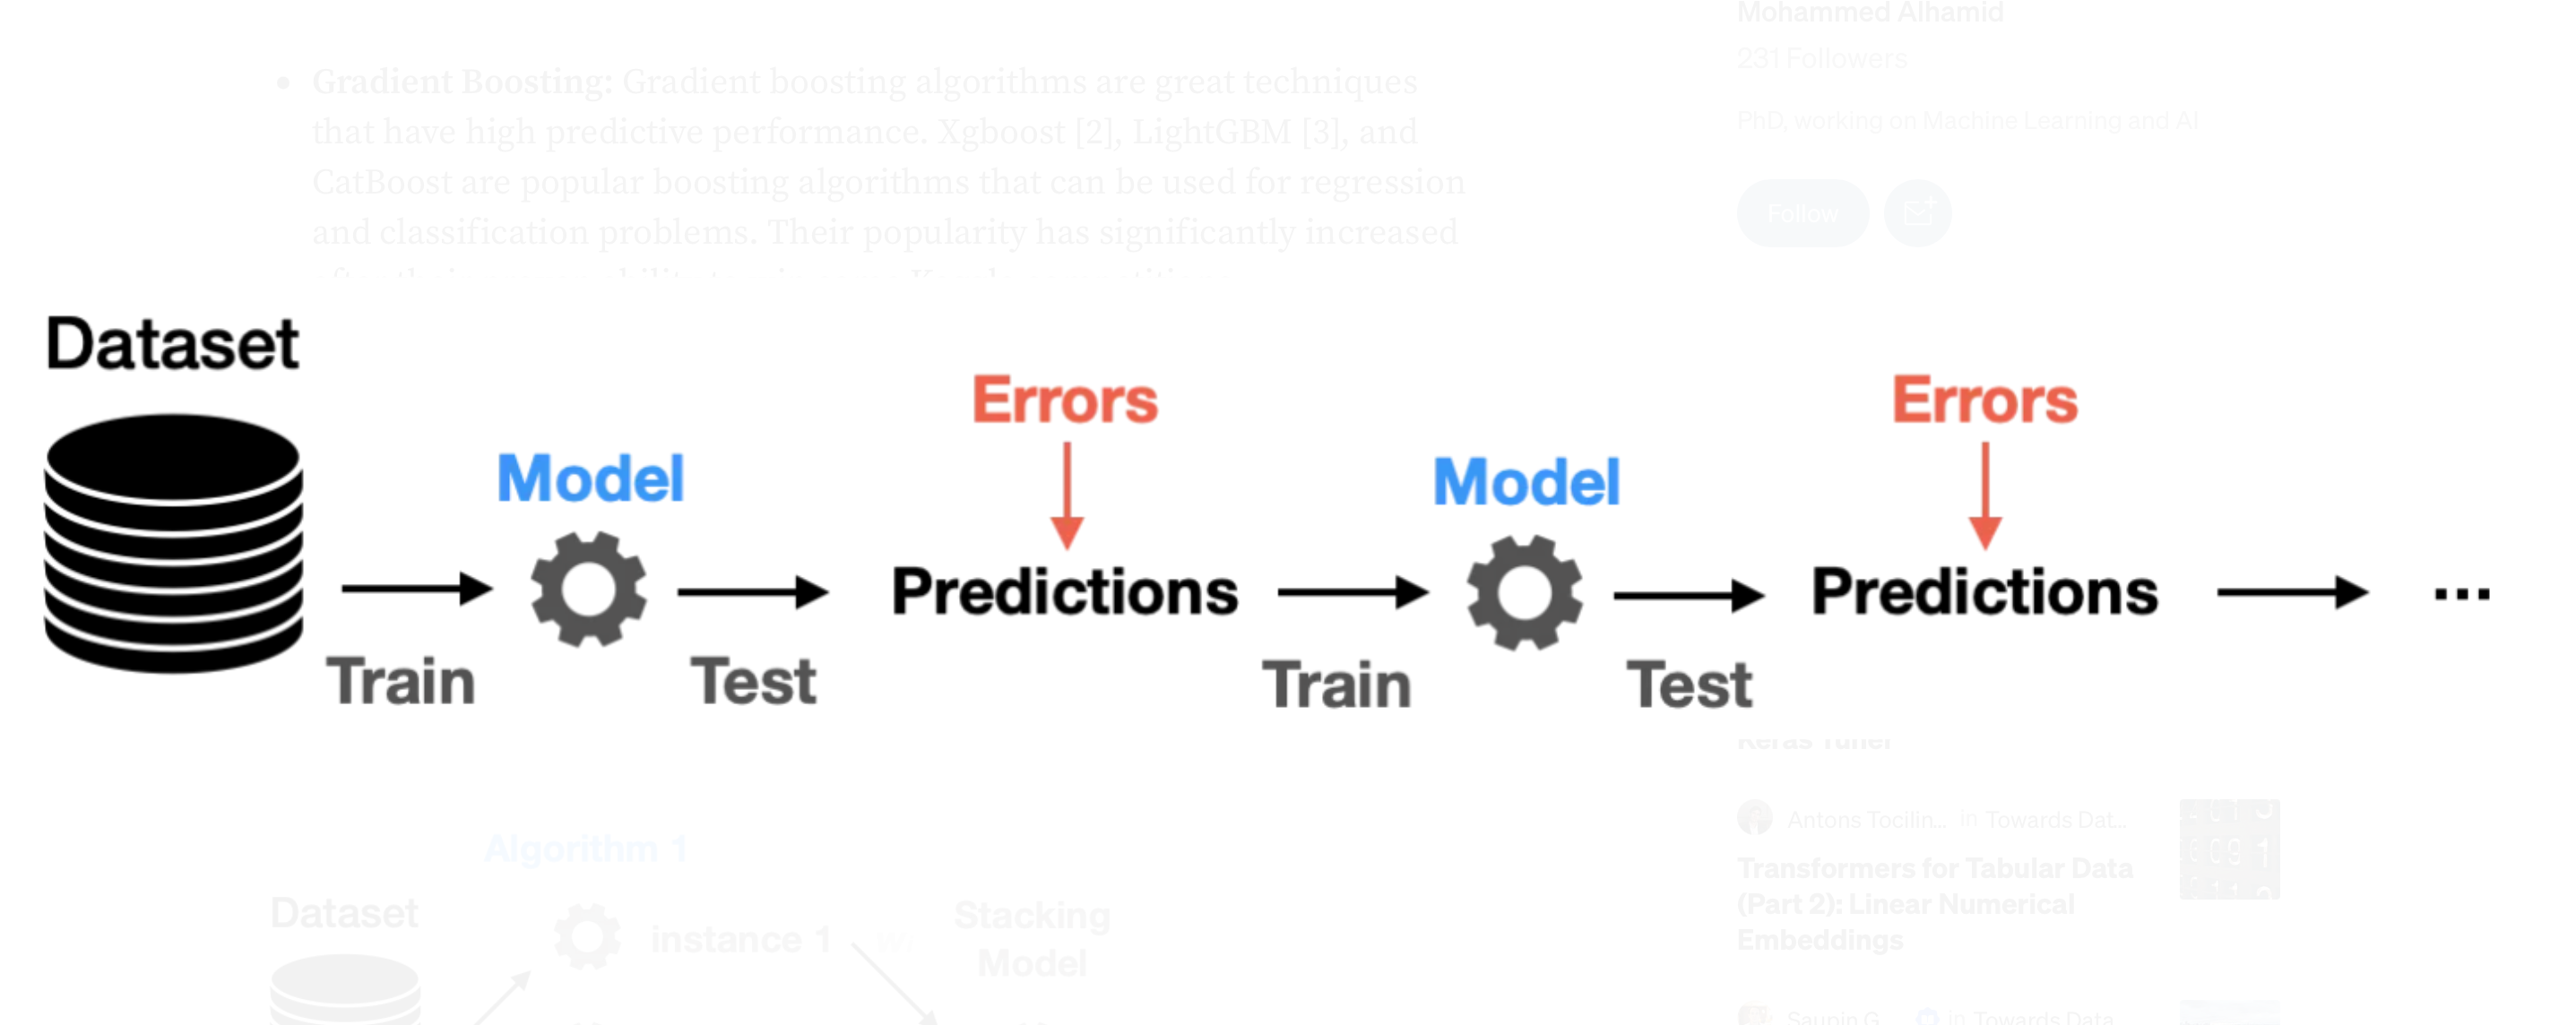

In [137]:
Image(filename='boosting.png')

In [138]:
!pip install -q xgboost

Mean Squared Error: 0.08336230626996466


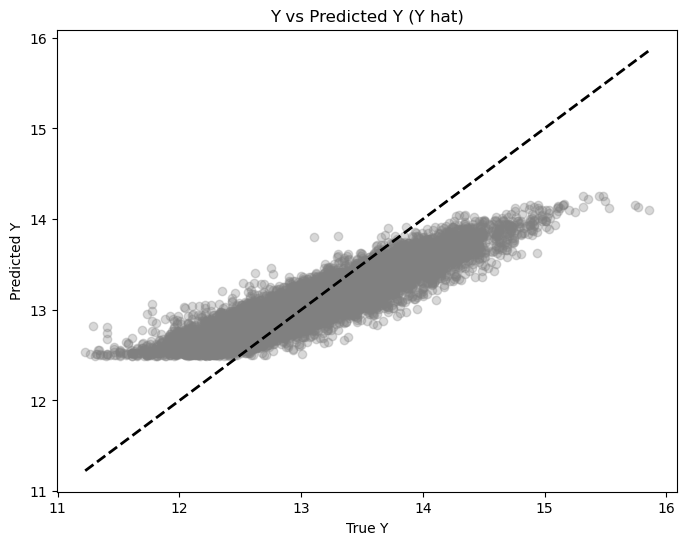

In [139]:
import xgboost as xgb
from sklearn.model_selection import cross_val_predict

# Convert the data into XGBoost's DMatrix format
dtrain = xgb.DMatrix(X, label=y)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Train the XGBoost model with the optimal number of boosting rounds
model = xgb.train(params, dtrain, num_boost_round= 10)

# Make predictions 
y_pred = model.predict(dtrain)

# Calculate and print the Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='grey', alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Y vs Predicted Y (Y hat)')
plt.show()

## Example 2 For Decision Tree on a randomly generated dataset

We will begin by fitting a tree to a simulated data. I want you to see the fitting a tree is in fact clustering the data. 


The first part of the code below, generates a random dataset. 

In [140]:
import numpy as np
# Simulate some data and plot it
n = 1000
Xsim = np.random.rand(n,2)
def Ey_x(x):
    return 1/3*(np.sin(5*x[0])*np.sqrt(x[1])*np.exp(-(x[1]-0.5)**2))
#np.apply_along_axis applys a function (Ey_x here) to 1-D slices along the given axis which is Xsim here
ysim = np.apply_along_axis(Ey_x, 1, Xsim) + np.random.randn(n)*0.1

In [141]:
import plotly.graph_objects as go

In [142]:
#defining a 3D scatter plot to show the data
def surface_scatter_plot(X,y,f, xlo=0., xhi=1., ngrid=50,
                         width=860, height=700, f0=Ey_x, show_f0=False):
    scatter = go.Scatter3d(x=X[:,0],y=X[:,1],z=y,
                           mode='markers',
                           marker=dict(size=2, opacity=0.3)
    )
    xgrid = np.linspace(xlo,xhi,ngrid)
    ey = np.zeros((len(xgrid),len(xgrid)))
    ey0 = np.zeros((len(xgrid),len(xgrid)))
    #colorscale = [[0, colors[0]], [1, colors[2]]]
    for i in range(len(xgrid)):
        for j in range(len(xgrid)):
            ey[j,i] = f([xgrid[i],xgrid[j]])
            ey0[j,i]= f0([xgrid[i],xgrid[j]])
    surface = go.Surface(x=xgrid, y=xgrid, z=ey,  opacity=1.0)
    if (show_f0):
        surface0 = go.Surface(x=xgrid, y=xgrid, z=ey0, opacity=0.8)
        layers = [scatter, surface, surface0]
    else:
        layers = [scatter, surface]
    fig = go.FigureWidget(
        data=layers,
        layout = go.Layout(
            autosize=True,
            scene=dict(
                xaxis_title='X1',
                yaxis_title='X2',
                zaxis_title='Y'
            ),
            width=width,
            height=height
        )
    )
    return fig

fig = surface_scatter_plot(Xsim, ysim, Ey_x)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
              'type': 'scatter3d',
              'uid': 'cebf3d29-7a2b-4b54-bd7b-104199ecbecf',
              'x': array([0.89965778, 0.01520211, 0.59099962, ..., 0.98093029, 0.87557764,
                          0.01602911]),
              'y': array([0.05775723, 0.47410884, 0.96753092, ..., 0.32231107, 0.92773176,
                          0.9060646 ]),
              'z': array([-0.13949468,  0.0425684 , -0.03038585, ..., -0.12779542, -0.25102411,
                           0.28598939])},
             {'opacity': 1.0,
              'type': 'surface',
              'uid': 'cf1b4d83-fe78-4a8f-a5f2-1cb66e0a8991',
              'x': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265, 0.10204082,
                          0.12244898, 0.14285714, 0.16326531, 0.18367347, 0.20408163, 0.2244898 ,
                          0.24489796, 0.26530612, 0.28571429, 0.30612245, 0.3265306

We now fit a regression tree to this data and plot the predicted
regression surface.
you can specify the pruning parameter by setting `ccp_alpha` to your desired number (something between zero and 1). The higher the penalty the smaller the tree. For your project, you should set this parameter. Start by setting the penalty equal to 0.1.

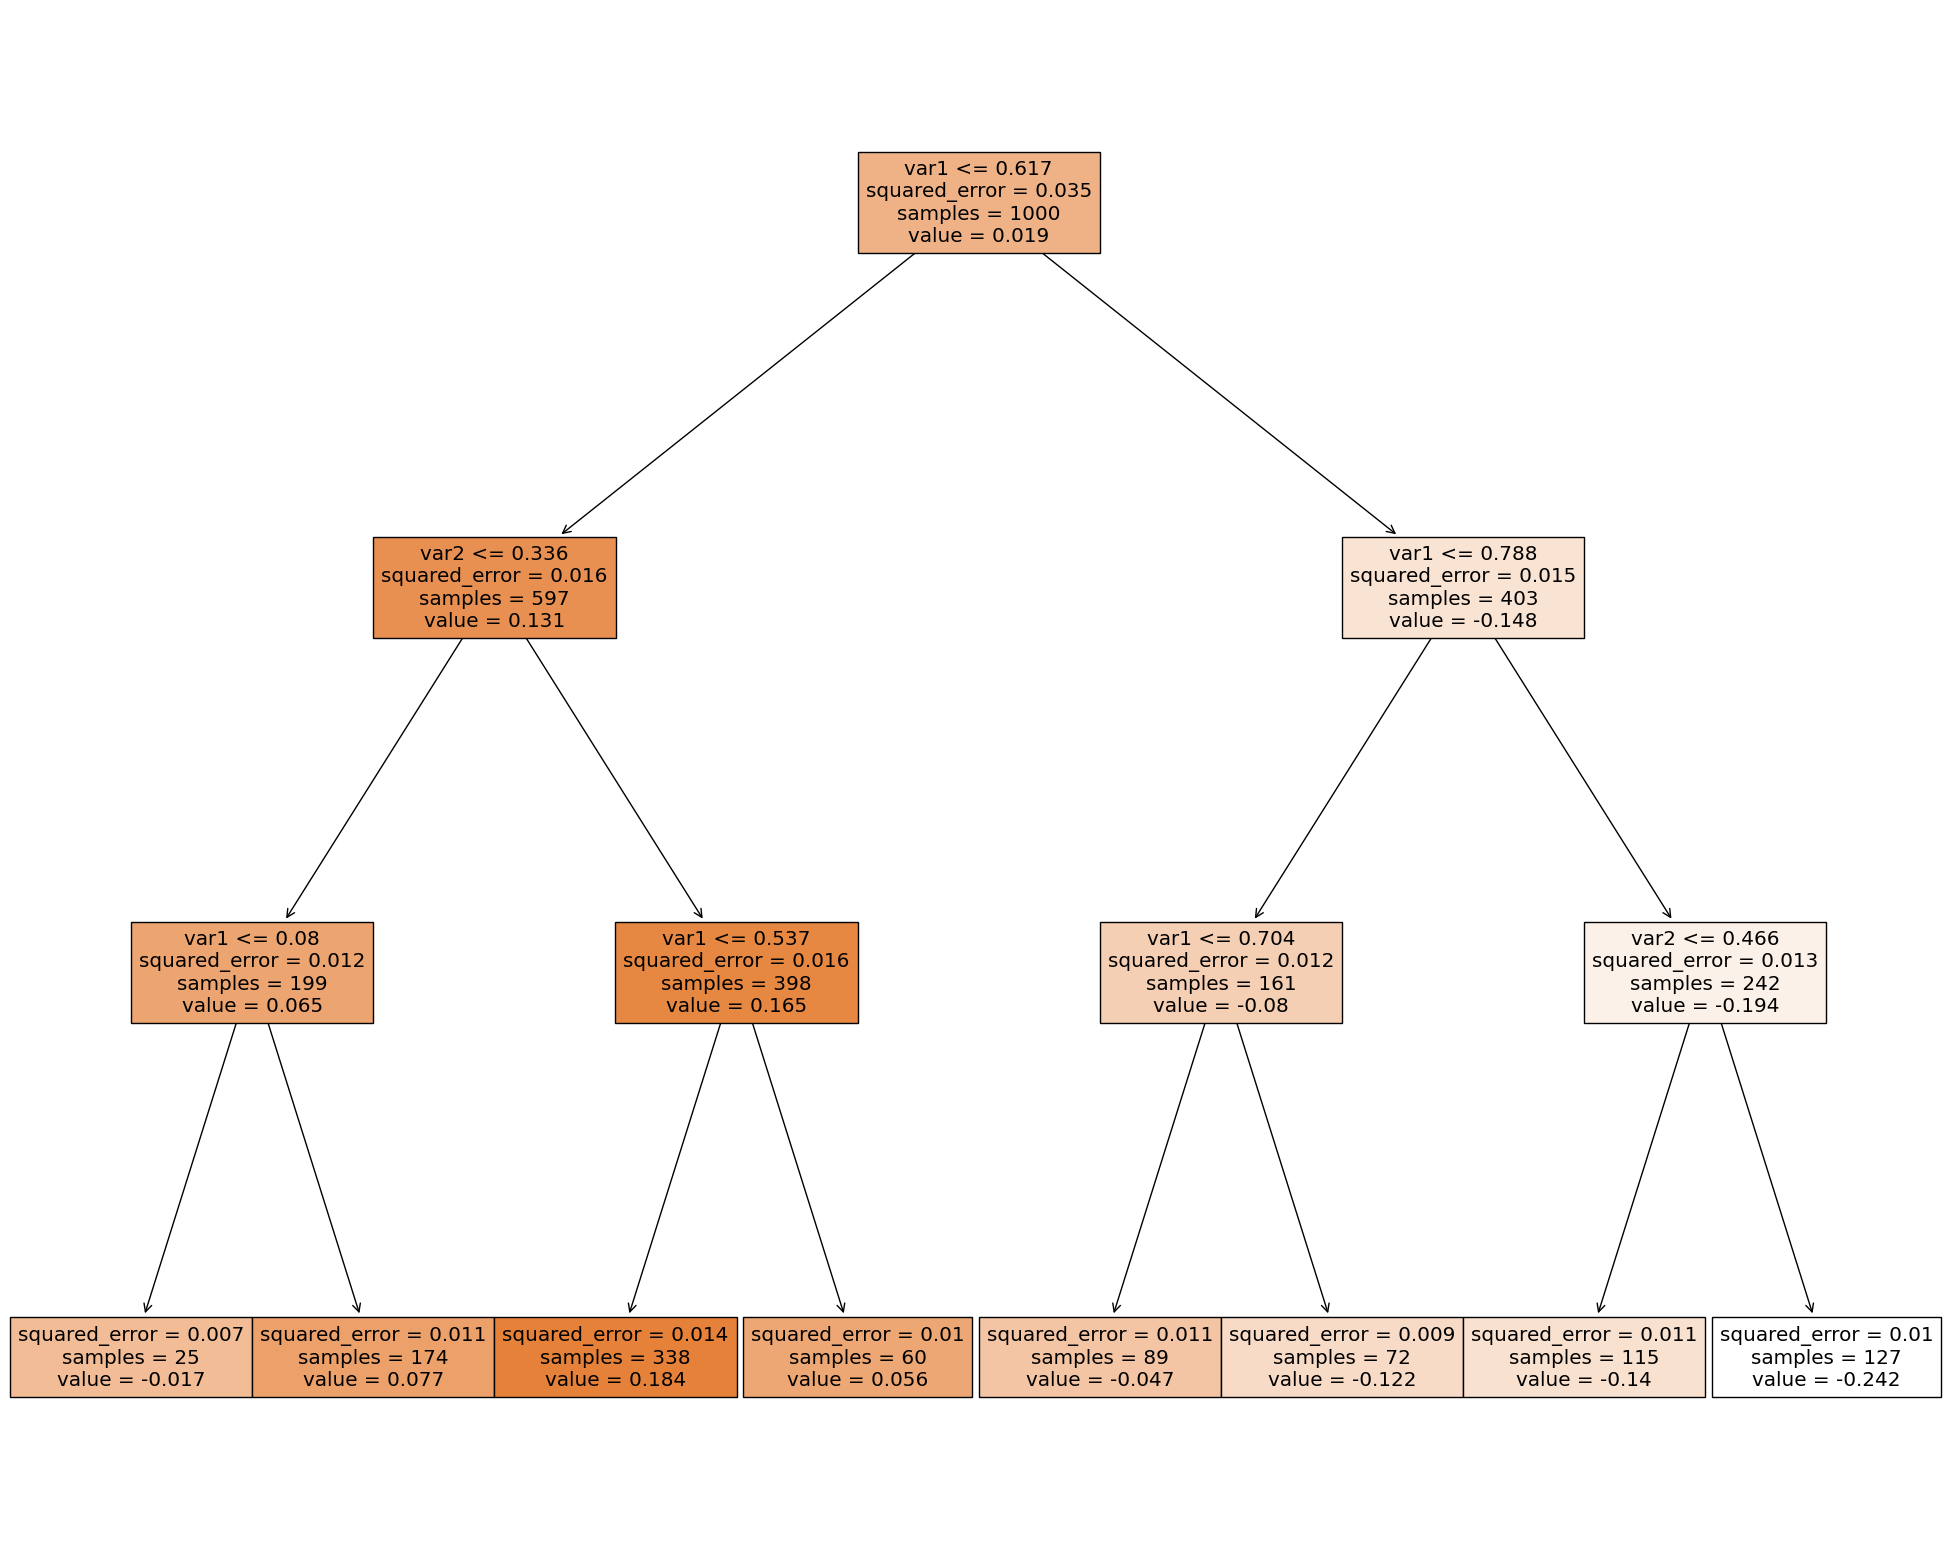

In [143]:
fitted_tree = tree.DecisionTreeRegressor(max_depth=3).fit(Xsim,ysim)
fig = plt.figure(figsize=(25,20))
fig = tree.plot_tree(fitted_tree, feature_names=["var1", "var2"], filled=True)


In [144]:
fig=surface_scatter_plot(
    Xsim, ysim, lambda x: fitted_tree.predict([x]), show_f0=True
)
fig

FigureWidget({
    'data': [{'marker': {'opacity': 0.3, 'size': 2},
              'mode': 'markers',
              'type': 'scatter3d',
              'uid': 'a07a1ce7-fdd5-4772-8205-9110edadd993',
              'x': array([0.89965778, 0.01520211, 0.59099962, ..., 0.98093029, 0.87557764,
                          0.01602911]),
              'y': array([0.05775723, 0.47410884, 0.96753092, ..., 0.32231107, 0.92773176,
                          0.9060646 ]),
              'z': array([-0.13949468,  0.0425684 , -0.03038585, ..., -0.12779542, -0.25102411,
                           0.28598939])},
             {'opacity': 1.0,
              'type': 'surface',
              'uid': '95fb4874-a269-4f56-a612-fc852ebbaa0a',
              'x': array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265, 0.10204082,
                          0.12244898, 0.14285714, 0.16326531, 0.18367347, 0.20408163, 0.2244898 ,
                          0.24489796, 0.26530612, 0.28571429, 0.30612245, 0.3265306

As you can see, predictions from regression trees are piecewise-constant on rectangular regions. The boundaries of these regions are
determined by a decision tree. The following code displays the
decision graph.

In my view, in a few years most econ papers will have a ML part. Why is it new in econ while it is so easy to run and works better than simple linear regression? The answer is that we care a lot about interpretability of the results compared to very good prediction. We care more abou the causal effect of a variable. Causal `ML` and its application in economics is a hot topic.  